In [13]:
#python 3.10.12
from IPython.display import clear_output
# %pip install datasets evaluate rouge_score torch sacremoses -q
# %pip install transformers==4.28.0
# %pip install -U accelerator
# %pip install -U transformers[torch] transformers[sentencepiece]
clear_output()

In [14]:
model_name = 'blip-indo_v0.1'

model_dir = f'./models/{model_name}'
output_dir = f'{model_dir}/image-captioning-output'
model_output_dir = f'{model_dir}/blip-gpt-model'

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [16]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [17]:
from transformers import BlipForConditionalGeneration, AutoProcessor
import torch

model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base")
processor = AutoProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)
clear_output()


In [18]:
# # image feature extractor
# feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# # text tokenizer
# tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

In [19]:
# # GPT2 only has bos/eos tokens but not decoder_start/pad tokens
# tokenizer.pad_token = tokenizer.eos_token

# # update the model config
# model.config.eos_token_id = tokenizer.eos_token_id
# model.config.decoder_start_token_id = tokenizer.bos_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

In [20]:
model.save_pretrained(model_output_dir)
# feature_extractor.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [21]:
from datasets import load_dataset, Dataset, DatasetDict
# ds = load_dataset("./loader/coco-loader.py", "2017", data_dir="/home/bintangkevin29/kuliah/image-classificaton-keras/datasets")
ds = load_dataset("ydshieh/coco_dataset_script", "2017", data_dir="/home/bintangkevin29/kuliah/image-classificaton-keras/datasets", split="train")
ds = Dataset.from_dict(ds[0:591])

# raw_ds_train = Dataset.from_dict(ds['train'][0:5917])


Found cached dataset coco_dataset_script (/home/bintangkevin29/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-dac240ed69e76ccf/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f)


In [22]:
ds[0]

{'image_id': 203564,
 'caption_id': 37,
 'caption': 'Replika sepeda dengan jam sebagai roda depan.',
 'height': 400,
 'width': 400,
 'file_name': '000000203564.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000203564.jpg',
 'image_path': '/home/bintangkevin29/.cache/huggingface/datasets/downloads/extracted/0d44b493bde96c91ab52b99c4c8b8cb9f2b6583ac7e032eeee6bbf2b6450ba3f/train2017/000000203564.jpg'}

In [26]:
from PIL import Image
import torch
from torch.utils.data import DataLoader

class ImageCapatioingDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=Image.open(item['image_path']).convert('RGB'), text=item["caption"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding


train_ds = ImageCapatioingDataset(ds, processor)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=2)

In [24]:
# from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# training_args = Seq2SeqTrainingArguments(
#     predict_with_generate=True,
#     evaluation_strategy="epoch",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     output_dir=output_dir,
# )

In [27]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 13.121809005737305
Loss: 10.247466087341309
Loss: 10.18618392944336
Loss: 10.21723747253418
Loss: 10.177000999450684
Loss: 10.202645301818848
Loss: 10.193254470825195
Loss: 10.15327262878418
Loss: 10.13198184967041
Loss: 10.122347831726074
Loss: 10.153167724609375
Loss: 10.152100563049316
Loss: 10.102413177490234
Loss: 10.079999923706055
Loss: 10.055469512939453
Loss: 10.082939147949219
Loss: 10.07910442352295
Loss: 10.026215553283691
Loss: 9.987570762634277
Loss: 10.022568702697754
Loss: 10.021336555480957
Loss: 10.024721145629883
Loss: 9.974143028259277
Loss: 9.869109153747559
Loss: 9.736628532409668
Loss: 9.619232177734375
Loss: 9.122991561889648
Loss: 8.954315185546875
Loss: 8.797990798950195
Loss: 8.517127990722656
Loss: 8.287296295166016
Loss: 8.030420303344727
Loss: 7.805815696716309
Loss: 7.597322940826416
Loss: 7.417969703674316
Loss: 7.258213043212891
Loss: 7.091279983520508
Loss: 6.909994602203369
Loss: 6.793474197387695
Loss: 6.644010066986084
Loss: 6.4730000

KeyboardInterrupt: 

In [ ]:
import evaluate
metric = evaluate.load("rouge")

In [ ]:
import numpy as np

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=default_data_collator,
)

In [ ]:
trainer.train()

/home/bintangkevin29/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.850500,0.735222,30.618100,10.169000,28.550000,28.539800,17.523715
2,0.657700,0.676332,33.621100,11.648900,31.728500,31.630800,17.766798


/home/bintangkevin29/miniconda3/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


TrainOutput(global_step=4440, training_loss=0.7243774688995637, metrics={'train_runtime': 1714.2124, 'train_samples_per_second': 10.355, 'train_steps_per_second': 2.59, 'total_flos': 3.203414531273392e+18, 'train_loss': 0.7243774688995637, 'epoch': 3.0})

In [ ]:
trainer.save_model(output_dir)

In [ ]:
tokenizer.save_pretrained(output_dir)

('./models/vit-gpt-indo_v0.1/vit-gpt-model/tokenizer_config.json',
 './models/vit-gpt-indo_v0.1/vit-gpt-model/special_tokens_map.json',
 './models/vit-gpt-indo_v0.1/vit-gpt-model/vocab.json',
 './models/vit-gpt-indo_v0.1/vit-gpt-model/merges.txt',
 './models/vit-gpt-indo_v0.1/vit-gpt-model/added_tokens.json',
 './models/vit-gpt-indo_v0.1/vit-gpt-model/tokenizer.json')

In [ ]:

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained(output_dir)
feature_extractor = ViTImageProcessor.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 24
num_beams = 10
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

def predict_one(image_path):
  showImg = Image.open(image_path)
  display(showImg)
  print(predict_step([image_path]))

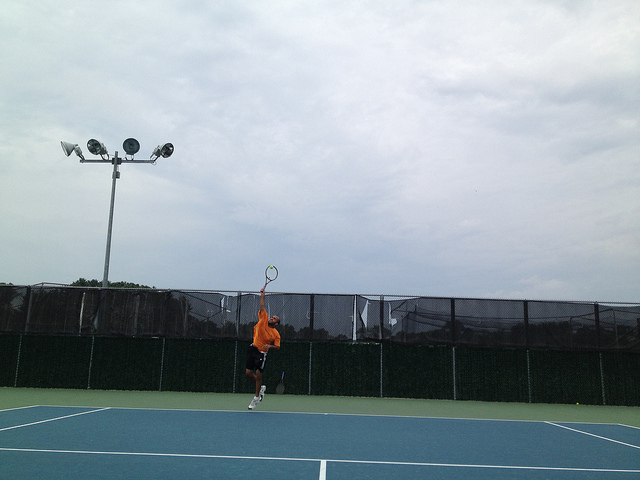

['Sebuah gambar pesawat terbang melalui langit biru.']


In [ ]:
predict_one('./image-samples/000000377914.jpg')
# predict_one('./image-samples/000000000025.jpg')